In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import distance as dist
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from matplotlib import cm

# Define functions: Kernel, interpolation

Vadere data

In [2]:
def load_vadere(df, scale, start_frame, end_frame, frame_skip):
    nPed = int(df['pedestrianId'].max())
    df['pedestrianId'] -= 1 # PID start with 0
    X = np.full((nPed,end_frame),np.nan)  # (pid,frame),  x == nan means the person is not in the field
    Y = np.full((nPed,end_frame),np.nan)  # (pid,frame)
    print("Interpolating pedestrian trajectory...")
    for pid,tid,st,et,sx,ex,sy,ey in tqdm(zip(df['pedestrianId'],df['targetId-PID2'],df['simTime'],df['endTime-PID1'],df['startX-PID1'],df['endX-PID1'],df['startY-PID1'],df['endY-PID1']),total=df.shape[0]):
        pid = int(pid)
        start_fr = max(int(round(st/frame_skip)),start_frame)
        end_fr = min(int(round(et/frame_skip))+1,end_frame)
        X[pid,start_fr:end_fr] = np.linspace(sx,ex, end_fr-start_fr)
        Y[pid,start_fr:end_fr] = np.linspace(sy,ey, end_fr-start_fr)
    return(scale*X,scale*Y)

Kernel function

In [3]:
def phi(const, point, centre):
    result = np.exp(- const * np.sum((point-centre) ** 2,axis=1))
    return result

Interpolation function

In [4]:
def intpl_func(points, centre, weight, const):
    return(np.sum(weight.ravel() * phi(const, points, centre)))

# Determine parameters

Vadere parameters

In [5]:
scale = 0.5
start_frame = 0
end_frame = 151
frame_skip = 1

rbf parameters

In [6]:
start_fr = 100 # start frame
end_fr = start_fr + 1 # end frame
const = 1 # constant in kernel
number_c = 30 # number_c ** 2 = the number of points of centre's of rbf function
number_k = 4 # the number of points in k-neighbourhood
cutoff_dist = 1
grid_number_x = 50 # dense of x-axis grid for plotting interpolated functions
grid_number_y = 50

# Data processing

Read data, and screen data for the particular frames

In [7]:
df = pd.read_csv('vadere_data/twoShops_btw.txt',header=0,delim_whitespace=True,dtype='f8')
df_vadere = load_vadere(df, scale, start_frame, end_frame, frame_skip)

ini_vector = pd.DataFrame([])
ini_vector['Xt'] = df_vadere[0][:,start_fr]
ini_vector['Yt'] = df_vadere[1][:,start_fr]
ini_vector['U'] = df_vadere[0][:,end_fr] - ini_vector['Xt']
ini_vector['V'] = df_vadere[1][:,end_fr] - ini_vector['Yt']
ini_vector = ini_vector.dropna()

 19%|█▊        | 1884/10121 [00:00<00:00, 18824.13it/s]

Interpolating pedestrian trajectory...


100%|██████████| 10121/10121 [00:00<00:00, 17753.33it/s]


# Calculate interpolation function

Calculate weight of interpolation functions

In [8]:
ini_xy = ini_vector.loc[:,['Xt','Yt']].values
print("Number of valid pedestrians: ",len(ini_vector))

min_x = min(ini_xy[:,0])
max_x = max(ini_xy[:,0])
min_y = min(ini_xy[:,1])
max_y = max(ini_xy[:,1])

rbf_x, rbf_y = np.meshgrid(np.linspace(min_x, max_x, number_c), np.linspace(min_y, max_y, number_c))
rbf_c = np.vstack([rbf_x.ravel(), rbf_y.ravel()]).T

phi_array = np.zeros((len(ini_xy), len(rbf_c)))
n_neighbour = 0
for i in range(len(ini_xy)):
    col_dist = np.sqrt(np.sum((rbf_c-ini_xy[i])**2,axis=1))
    if number_k>0:
        dist_sort_index = col_dist.argsort()
        nei_index = dist_sort_index[:number_k]
    else:
        nei_index = np.where(col_dist<cutoff_dist)[0]
        n_neighbour += len(nei_index)
    phi_array[i,nei_index] = phi(const, ini_xy[i], rbf_c[nei_index])
print("average number of neighbours: ",n_neighbour/len(ini_xy))

weight_x = lsqr(csc_matrix(phi_array), ini_vector['U'])[0]
weight_y = lsqr(csc_matrix(phi_array), ini_vector['V'])[0]

Number of valid pedestrians:  50
average number of neighbours:  0.0


Calculate interpolation functions

In [9]:
grid_x0 = np.linspace(0, scale * 30, grid_number_x)
grid_y0 = np.linspace(0, scale * 50, grid_number_y)

grid_x, grid_y = np.meshgrid(grid_x0, grid_y0)
grid_xy = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

intpl_u = []
intpl_v = []
for xy in grid_xy:
    intpl_u.append(intpl_func(xy, rbf_c, weight_x, const))
    intpl_v.append(intpl_func(xy, rbf_c, weight_y, const))

Draw figures

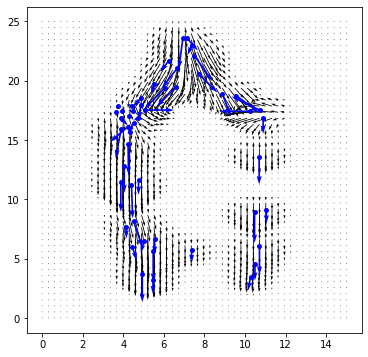

In [10]:
plt.figure(figsize=(6, 6))
plt.quiver(grid_xy[:,0], grid_xy[:,1], intpl_u, intpl_v)
plt.scatter(ini_xy[:,0], ini_xy[:,1], s=15, c='b')
plt.quiver(ini_xy[:,0], ini_xy[:,1], ini_vector['U'], ini_vector['V'], width=0.005, color='blue')
plt.show()